In [27]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from typing import Tuple


In [2]:
class TaskDataset(Dataset):
    def __init__(self, ids, imgs, labels, transform=None):
        self.ids = ids
        self.imgs = imgs
        self.labels = labels
        self.transform = transform


    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        if self.transform is not None:
            img = self.transform(img)
            if img.shape[0] == 1:
                img = img.repeat(3, 1, 1)
        label = int(self.labels[index])
        return id_, img, label

    def __len__(self):
        return len(self.ids)


In [28]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [09:03<00:00, 313551.00it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [29]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [78]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = torch.load("./ModelStealingPub.pt")
ids = range(len(dataset.imgs))
public_dataset = TaskDataset(ids=ids, imgs=dataset.imgs, labels=dataset.labels, transform=transform)
public_dataset = DataLoader(dataset=public_dataset, batch_size=32, shuffle=True)


In [64]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2),
                nn.Flatten(),
                nn.Linear(64*8*8, 128)
        )
        self.fc = nn.Linear(128, 44) 

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(F.dropout(x, p=0.5, training=self.training))
        x = self.fc(x)
        return F.softmax(x, dim=1)

In [66]:
def contrastive_loss(features, tau=0.5):
    batch_size = features.shape[0] // 2
    labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
    features = F.normalize(features, dim=1)
    similarity_matrix = torch.matmul(features, features.T)
    mask = torch.eye(labels.shape[0], device=labels.device).bool()
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
    logits = similarity_matrix / tau
    log_prob = F.log_softmax(logits, dim=1)
    loss = -log_prob * labels
    loss = loss.sum(1) / labels.sum(1)
    loss = loss.mean()
    return loss

In [67]:
encoder = CNNClassifier()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)

In [68]:
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = encoder(images)
        loss = contrastive_loss(output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss/len(public_dataset.dataset)}')

    losses.append(total_loss/len(public_dataset.dataset))

Epoch [1/10], Average Loss: 0.41282562938103307
Epoch [2/10], Average Loss: 0.4128190469375023
Epoch [3/10], Average Loss: 0.41282599087861865
Epoch [4/10], Average Loss: 0.4128182845665858
Epoch [5/10], Average Loss: 0.41281501285846417
Epoch [6/10], Average Loss: 0.412817521920571
Epoch [7/10], Average Loss: 0.4128195463694059
Epoch [8/10], Average Loss: 0.4128163427206186
Epoch [9/10], Average Loss: 0.4128154896406027
Epoch [10/10], Average Loss: 0.4128206089093135


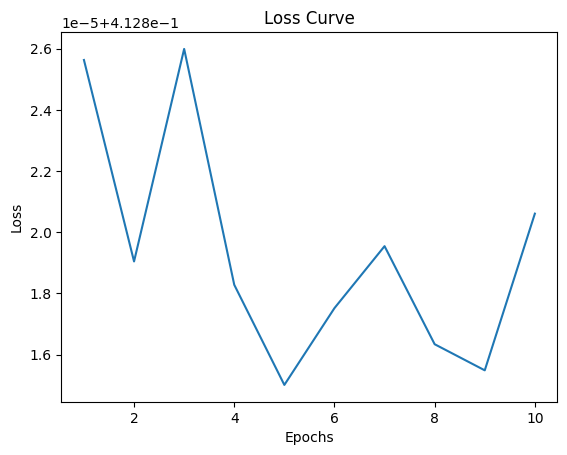

In [69]:
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [70]:
test_loss = 0.0
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        outputs = encoder(images)
        loss = contrastive_loss(outputs)
        test_loss += loss.item()
print(f'Test Loss: {test_loss/len(testset)}')

Test Loss: 0.1074122413635254


In [71]:
probabilities = []
true_labels = []
encoder.eval()
with torch.no_grad():
    for batch_idx, (_,imgs, labels) in enumerate(public_dataset):
        outputs = encoder(imgs)
        probabilities.extend(outputs.numpy())
        true_labels.extend(labels.numpy())

In [72]:
num_clusters = 10

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(probabilities)


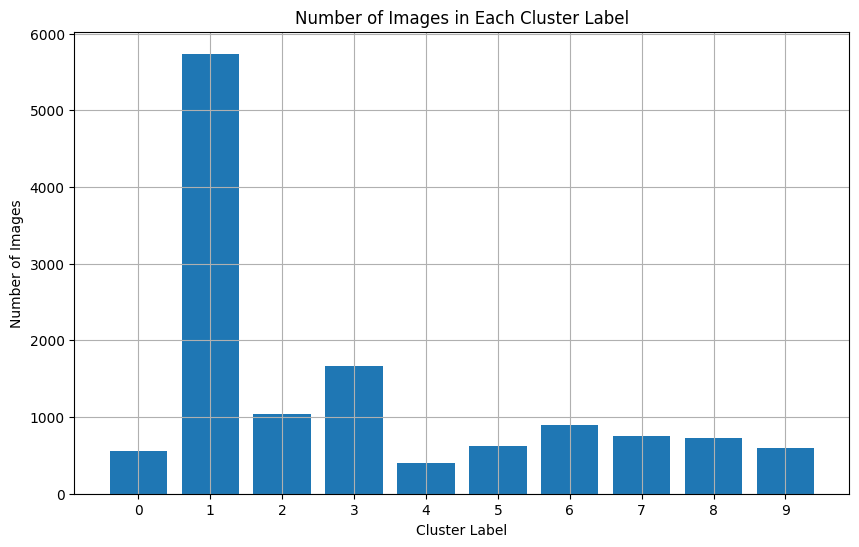

In [73]:
cluster_label_counts = np.zeros(10)
for cluster_id in range(10):
    cluster_label_counts[cluster_id] = np.sum(cluster_labels == cluster_id)

# Plot the number of images in each cluster label
plt.figure(figsize=(10, 6))
plt.bar(range(10), cluster_label_counts, tick_label=range(10))
plt.xlabel('Cluster Label')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Cluster Label')
plt.grid(True)
plt.show()

In [79]:
cluster_buckets = {cluster_id: [] for cluster_id in range(10)}
for i in range(len(dataset.imgs)):
    cluster_buckets[cluster_labels[i]].append((dataset.imgs[i], dataset.labels[i]))

In [80]:
total = 0
for cluster_id, bucket in cluster_buckets.items():
    total += len(bucket)
    print(f'Cluster {cluster_id}: {len(bucket)} images')
print(f'Total: {total} images')

Cluster 0: 558 images
Cluster 1: 5739 images
Cluster 2: 1035 images
Cluster 3: 1663 images
Cluster 4: 403 images
Cluster 5: 622 images
Cluster 6: 901 images
Cluster 7: 748 images
Cluster 8: 730 images
Cluster 9: 601 images
Total: 13000 images
